
# Bank Customer Churn analysis

## Vandit Sheth


In [ ]:
!pip install scikit-plot

## Basic Setup

In [ ]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import scikitplot as skplt

label_size = 17

plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 2
plt.rcParams['ytick.labelsize'] = label_size - 2
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['legend.fontsize'] = label_size - 2

random_state = 42
scoring_metric = 'recall'
comparison_dict = {}
comparison_test_dict = {}

In [ ]:
def plot_continuous(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    
    sns.distplot(df_remained[feature], bins = 15, color = colors[0], label = 'Remained', hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    sns.distplot(df_churned[feature], bins = 15, color = colors[1], label = 'Churned', hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    ax1.set_title('{} distribution - Histogram'.format(feature))
    ax1.set_ylabel('Counts')
    ax1.legend()

    sns.boxplot(x = 'Exited', y = feature, data = train_df, palette = colors, ax = ax2)
    ax2.set_title('{} distribution - Box plot'.format(feature))
    ax2.set_xlabel('Status')
    ax2.set_xticklabels(['Remained', 'Churned'])

    plt.tight_layout();
    
    
def plot_categorical(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    sns.countplot(x = feature, hue = 'Exited', data = train_df, palette = colors, ax = ax1)
    ax1.set_ylabel('Counts')
    ax1.legend(labels = ['Retained', 'Churned'])
    
    sns.barplot(x = feature, y = 'Exited', data = train_df, palette = colors2 , ci = None, ax = ax2)
    ax2.set_ylabel('Churn rate')
    
    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])
    
    plt.tight_layout();
    
def plot_learning_curve(estimator, estimator_name, X, y, cv = None, train_sizes = np.linspace(0.1, 1.0, 5)):
                 
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = -1, 
                                                            train_sizes = train_sizes, scoring = 'accuracy')
    
    train_scores_mean, train_scores_std = np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
    test_scores_mean, test_scores_std = np.mean(test_scores, axis = 1), np.std(test_scores, axis = 1)
            
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'dodgerblue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'darkorange')
    
    plt.plot(train_sizes, train_scores_mean, color = 'dodgerblue', marker = 'o', linestyle = '-', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, color = 'darkorange', marker = 'o', linestyle = '-', label = 'Cross-validation Score')
    plt.title(estimator_name)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc = 'best')
            
    plt.tight_layout();
    
def plot_conf_mx(cm, classifier_name, ax):
    sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'fontsize': 24}, ax = ax)
    ax.set_title('{}'.format(classifier_name))
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Remained', 'Churned'])
    ax.set_ylabel('True Label') 
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Remained', 'Churned']);
    
def plot_feature_imp(classifier, classifier_name, color, ax):

    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

    importances.plot.barh(color = color, edgecolor = 'firebrick', legend = False, ax = ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');
    
def clf_performance(classifier, classifier_name, classifier_name_abv):
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items() :
        print ('      {}: {}'.format(key, value))
    
    y_pred_pp = cross_val_predict(classifier.best_estimator_, X_train, y_train, cv = 5, method = 'predict_proba')[:, 1]
    y_pred = y_pred_pp.round()
    
    cm = confusion_matrix(y_train, y_pred, normalize = 'true')
    
    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    
    comparison_dict[classifier_name_abv] = [accuracy_score(y_train, y_pred), 
                                            precision_score(y_train, y_pred),
                                            recall_score(y_train, y_pred),
                                            roc_auc_score(y_train, y_pred_pp),
                                            fpr, tpr]    

    fig, ax = plt.subplots(figsize = (5, 4))
    
    plot_conf_mx(cm, '', ax)    
    plt.tight_layout();
    
def test_func(classifier, classifier_name):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    
    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred), 
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]
    
    plt.title(classifier_name)
    sns.heatmap(cm, annot = True, annot_kws = {'fontsize': 18}, cmap = 'Blues')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Remained', 'Churned'])
    plt.ylabel('True Label') 
    plt.yticks([0.2, 1.4], ['Remained', 'Churned']);
    
print ('Functions defined!')

Functions defined!


## Importing Dataset and Pre-processing

In [ ]:
df = pd.read_csv('/content/Churn_Modelling.csv')
print ('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

This dataset contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

## Exploratory Data Analysis and Data Visualization

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


The most important things to note are:


1.   The age of customers ranges from 18 to 92, with a mean value approximately equal to 40
2.   The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3)
3.   Approximately 50% of customers are active.





In [ ]:
#Test set generation
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

train_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

print('Shape')
print('Train set: {} rows x {} columns'.format(train_df.shape[0], train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0], test_df.shape[1]))

Shape
Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


Target Variable: Exited

As observed earlier, the target variable is already encoded:

Exited = 0, for non-churned customers, and<br>
Exited = 1, for churned customers.

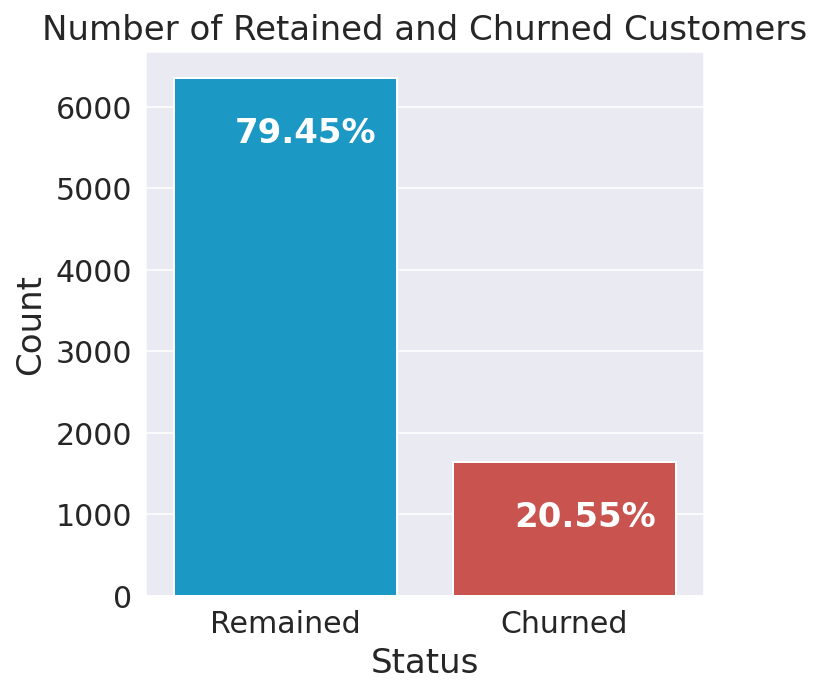

In [ ]:
colors = ['#00A5E0', '#DD403A']

fig = plt.figure(figsize = (5, 5))
sns.countplot(x = 'Exited', data = train_df, palette = colors)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label =  '{}%'.format(round( (value/train_df['Exited'].shape[0])*100, 2)) 
    plt.annotate(label, xy = (index - 0.18, value - 800), color = 'w', fontweight = 'bold', size = label_size)

plt.title('Number of Retained and Churned Customers')
plt.xticks([0, 1], ['Remained', 'Churned'])
plt.xlabel('Status')
plt.ylabel('Count');

The bank kept 80% of its Clients.

Notice that the dataset is skewed/imbalanced since the number of instances in the 'Remained' class outnumbers the number of instances in the 'Churned' class by a lot. Therefore, accuracy is probably not the best metric for model performance.


Different visualisation techniques apply to different types of variables, so it's useful to differentiate between continuous and categorical variables and look at them separately.

## Visualization for continuous Variables

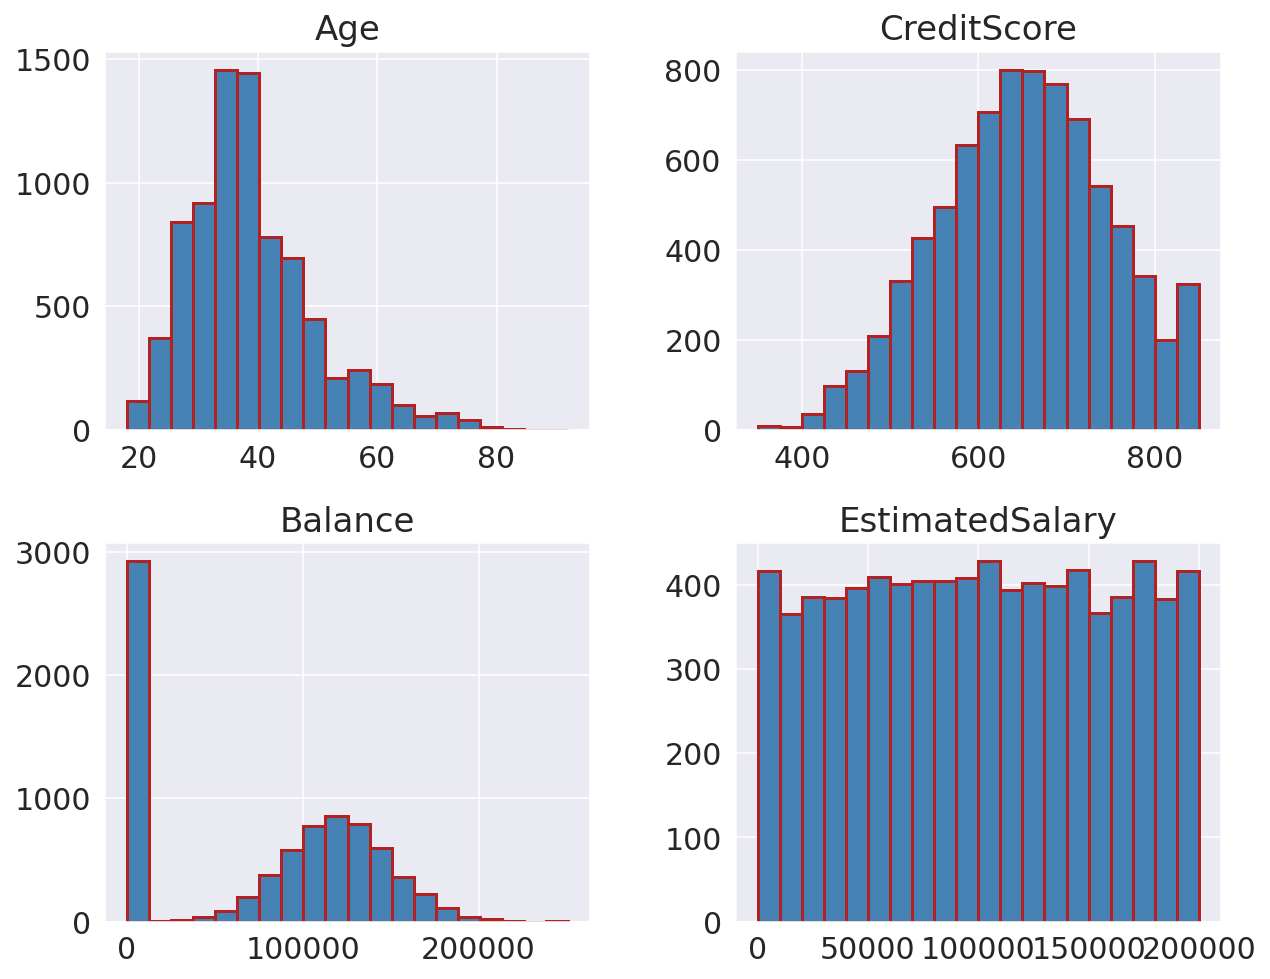

In [ ]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
train_df[continuous].hist(figsize = (10, 8), bins = 20, layout = (2, 2), 
                          color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5);

1. Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left<br>
2. Most values for 'CreditScore' are above 600<br>
3. If we ignore the fist bin, 'Balance' follows a fairly normal distribution <br>
4. The distribution of 'EstimatedSalary' is more or less uniform and provides little information

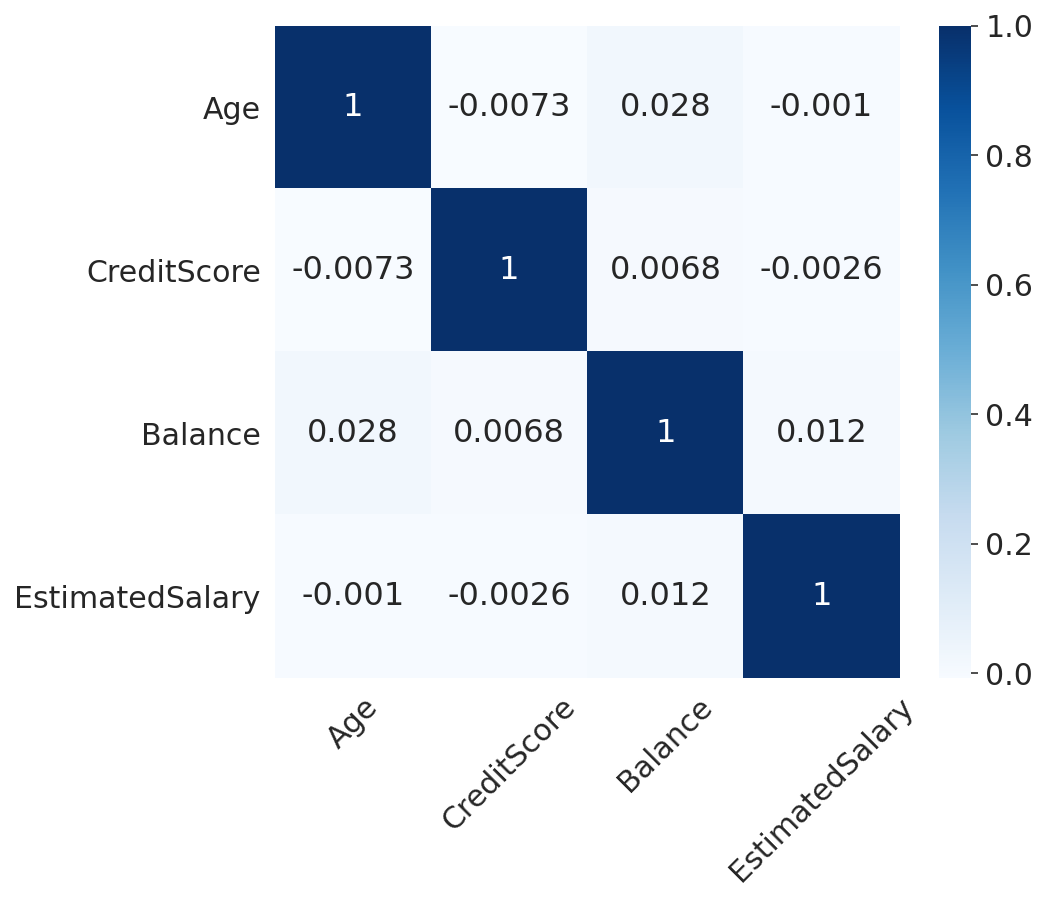

In [ ]:
#Correlation
plt.figure(figsize = (7, 6))
ax = sns.heatmap(train_df[continuous].corr(), annot = True, annot_kws = {'fontsize': 16}, cmap = 'Blues')

ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 360);

There is no significant intercorrelation between the features, so not need to worry about multicollinearity.



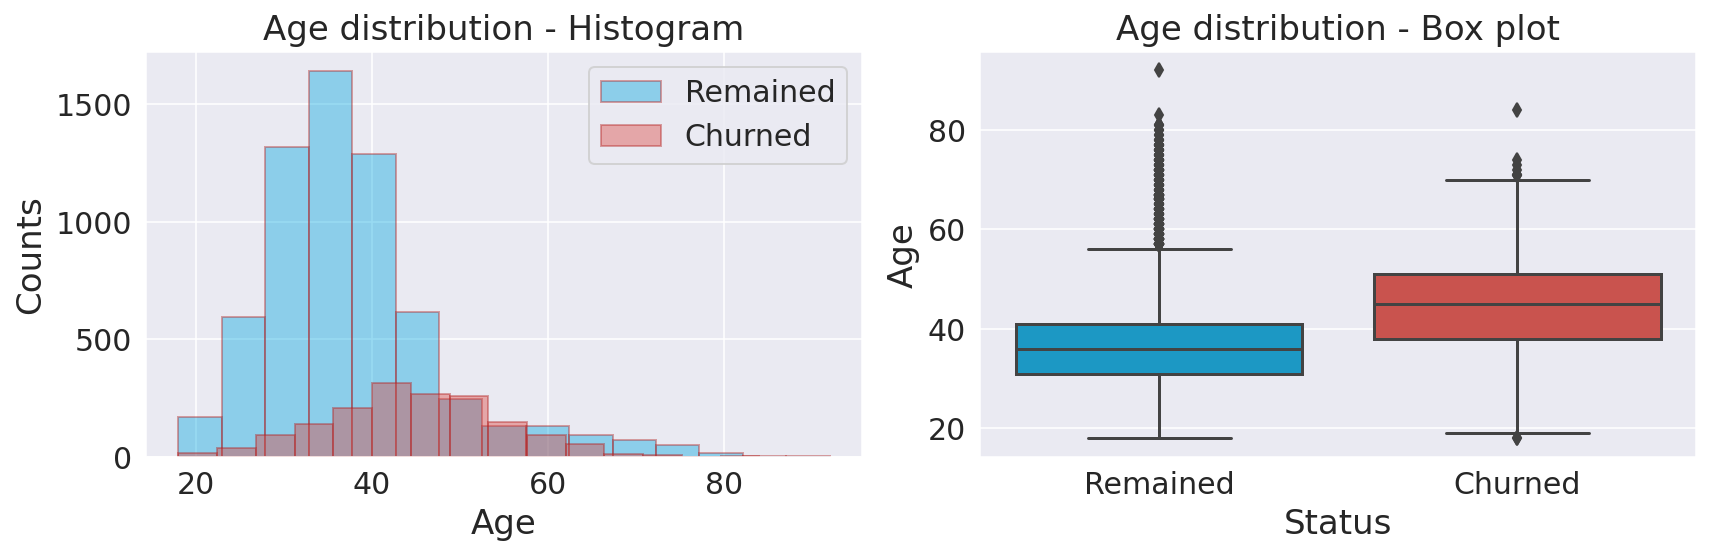

In [ ]:
df_churned = train_df[train_df['Exited'] == 1]
df_remained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

There is a clear difference between age groups since older customers are more likely to churn. This could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

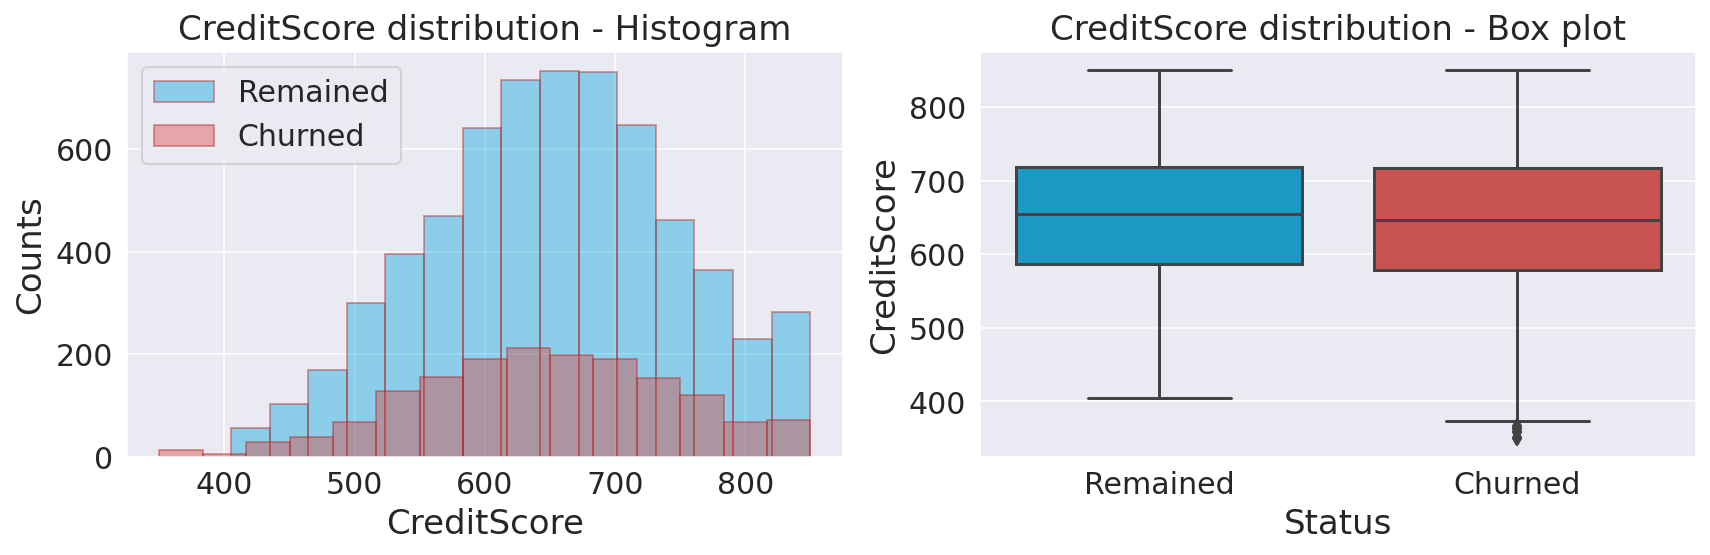

In [ ]:
plot_continuous('CreditScore')

There is no significant difference between retained and churned customers in terms of their credit score.



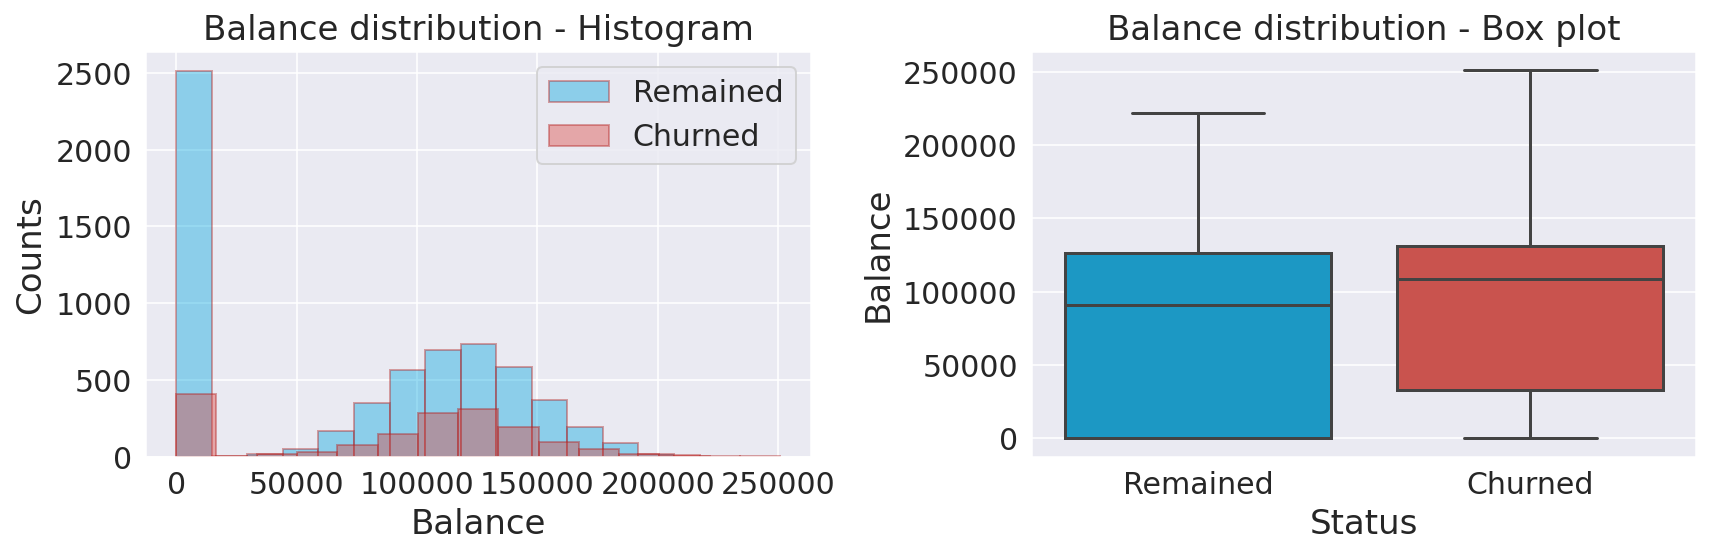

In [ ]:
plot_continuous('Balance')

Again, the two distributions are quite similar. There is a big percentage of non-churned customers with a low account balance.



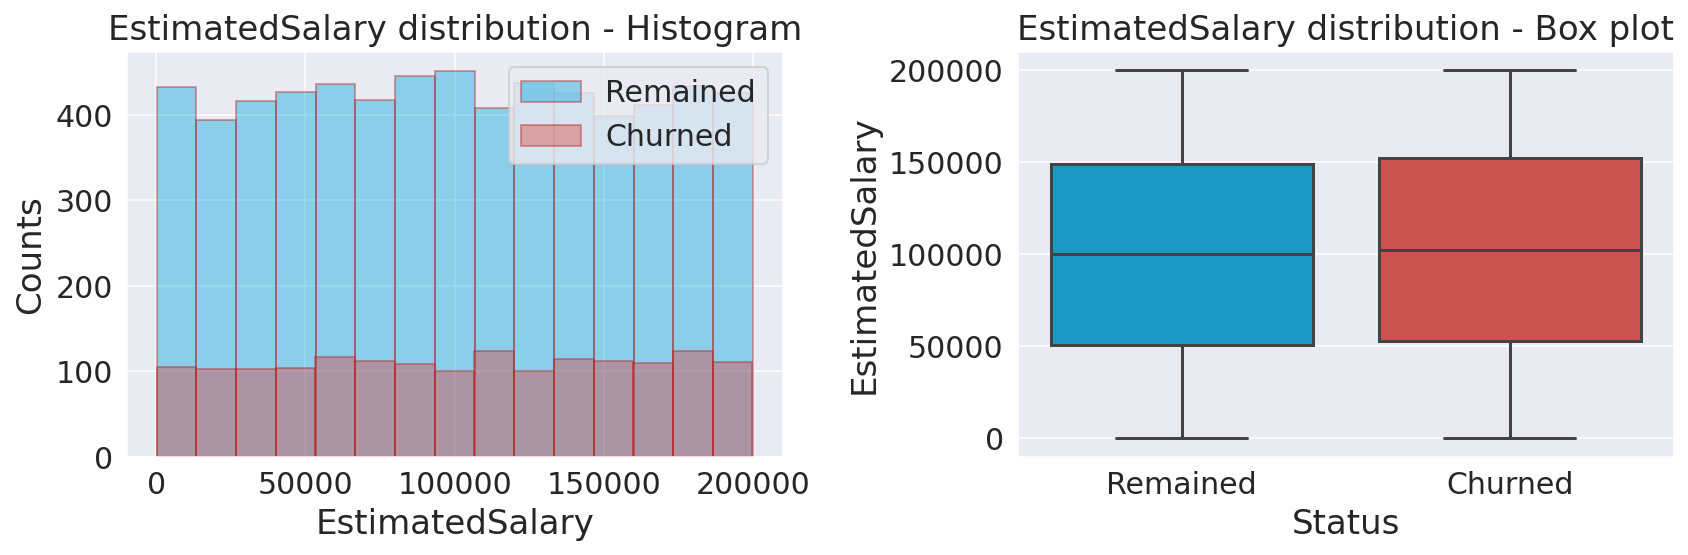

In [ ]:
plot_continuous('EstimatedSalary')

Both churned and retained customers display a similar uniform distribution for their salary. Consequently, we can conclude that salary doesn't have a significant effect on the likelihood to churn.

## Visualization for Categorical values


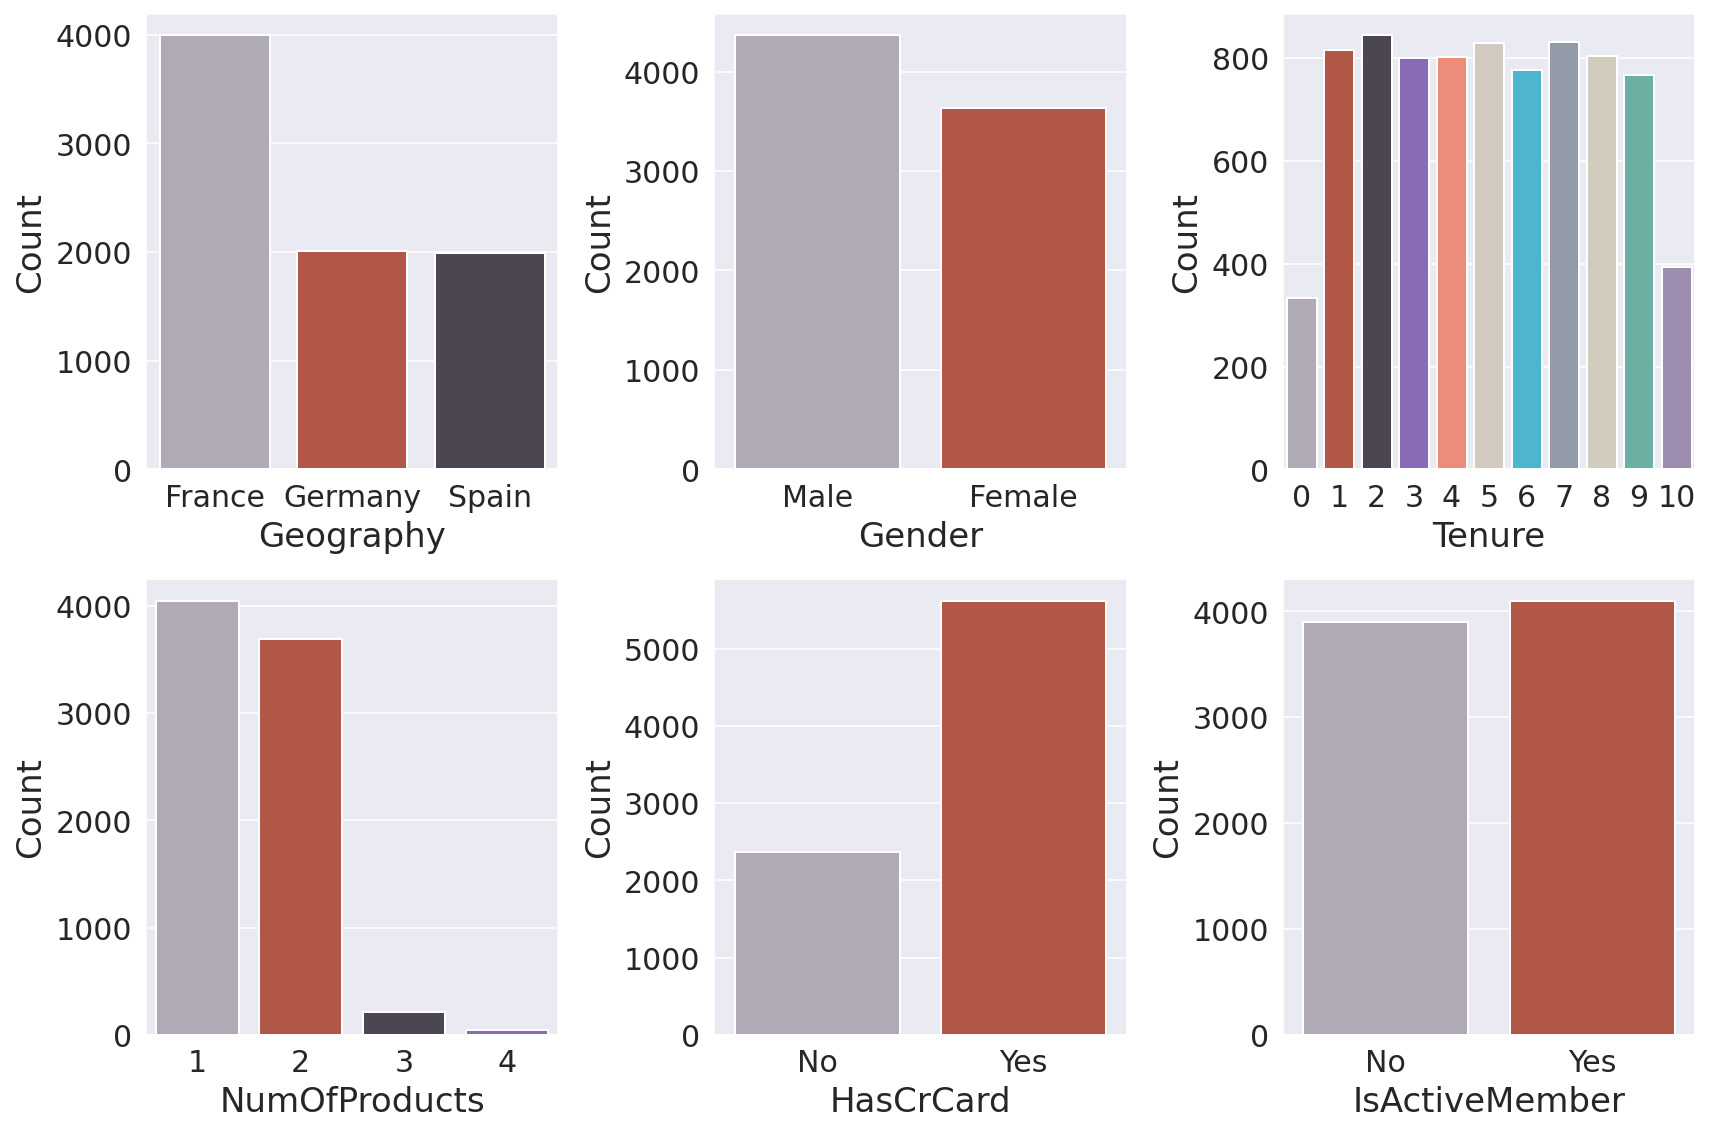

In [ ]:
colors2 = ['#B0A8B9', '#C34A36', '#4B4453', '#845EC2', '#FF8066', '#D5CABD', '#38c4e3', '#8f9aaa', '#d4cebb',  '#63BAAA', '#9D88B3']

cat_vars = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
df_cat = train_df[cat_vars]

fig, ax = plt.subplots(2, 3, figsize = (12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x = column, data = train_df, palette = colors2)
    
    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'): 
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

1. The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
2. There are more male customers than females,
3. Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
4. Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
5. A significant majority of customers has a credit card, and
6. Almost 50% of customers are not active.





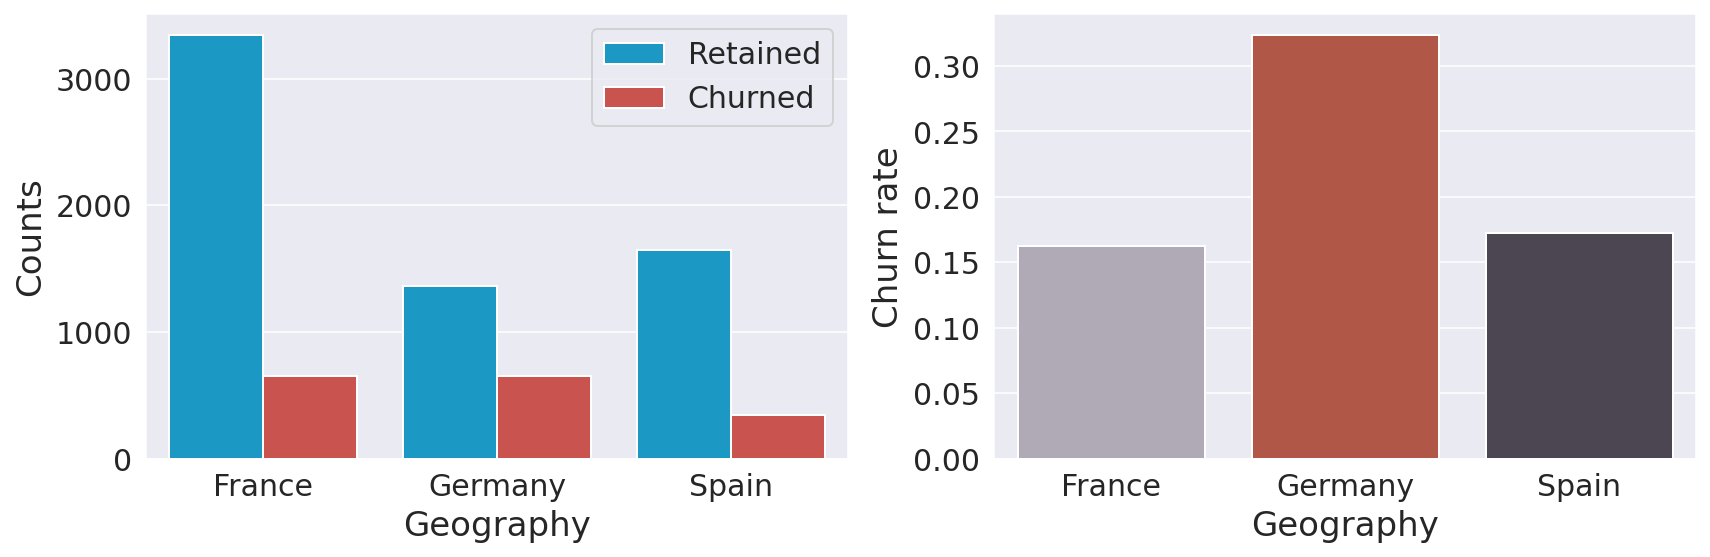

In [ ]:
plot_categorical('Geography')


Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding such as higher competition or different preferences for German customers.



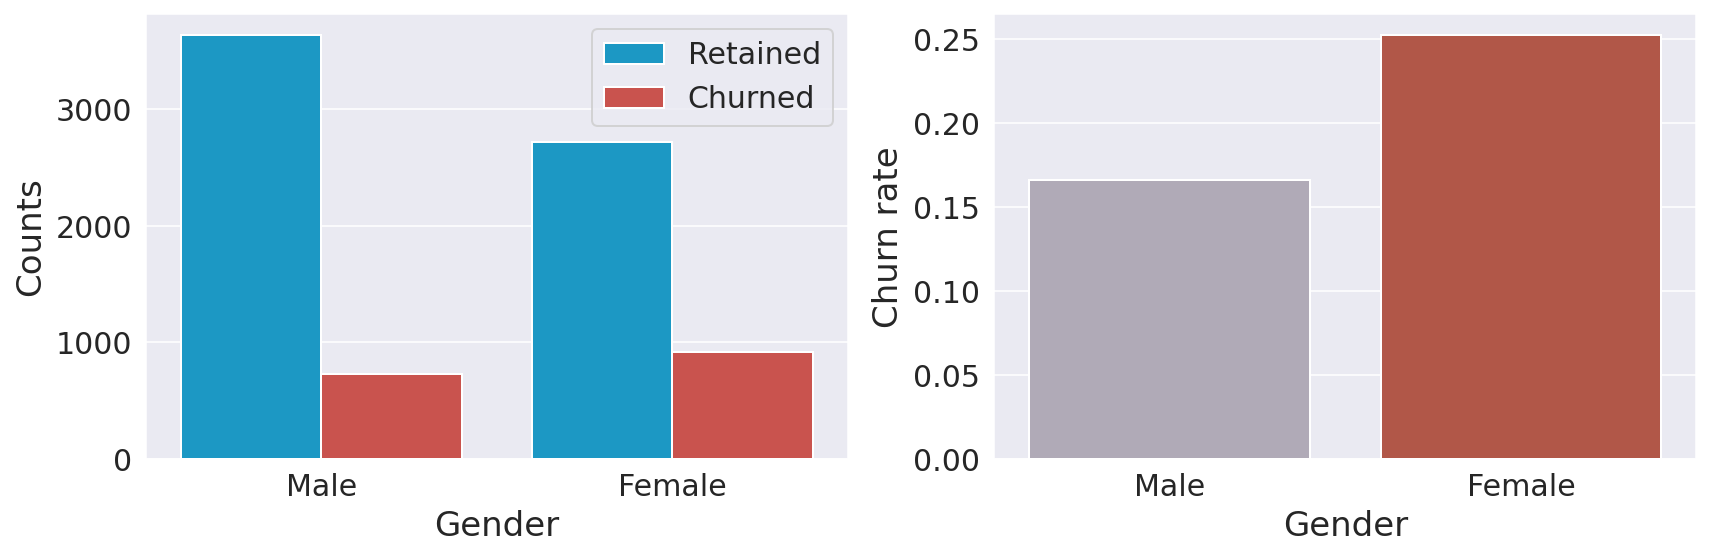

In [ ]:
plot_categorical('Gender')


Female customers are more likely to churn.



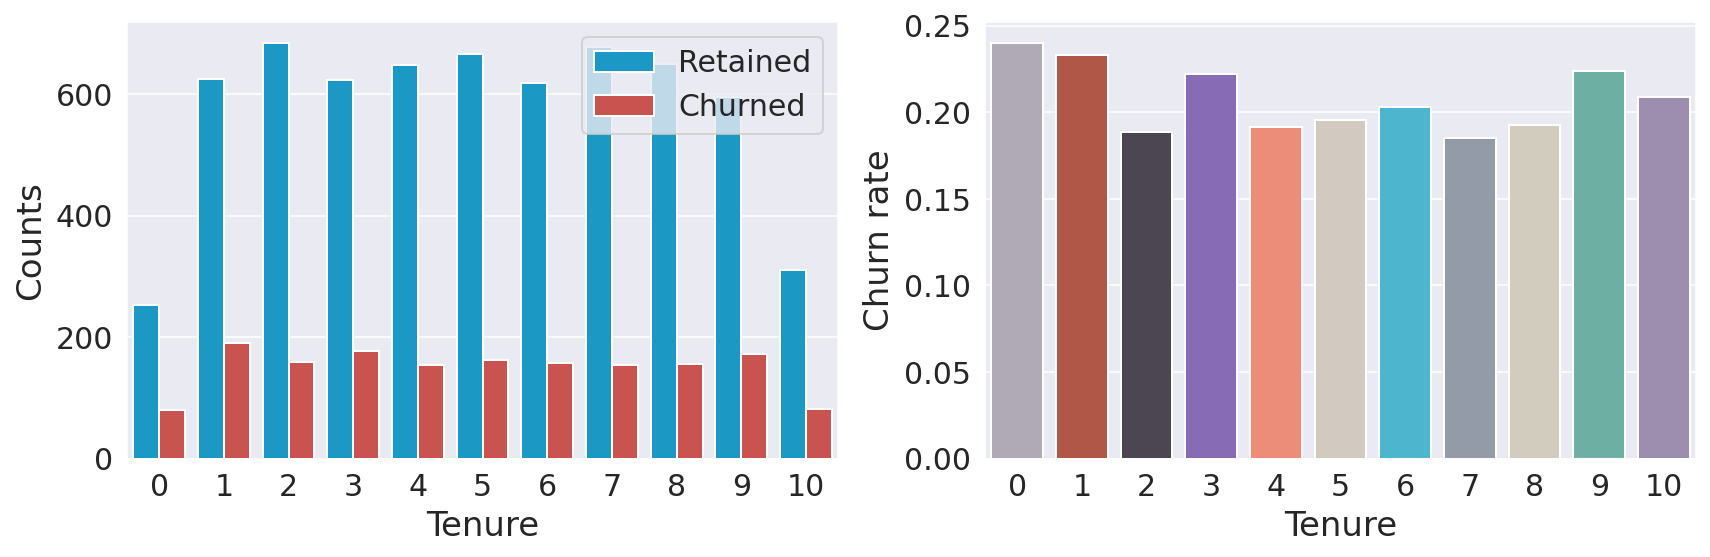

In [ ]:
plot_categorical('Tenure')

The number of years (tenure) doesn't seem to affect the churn rate.

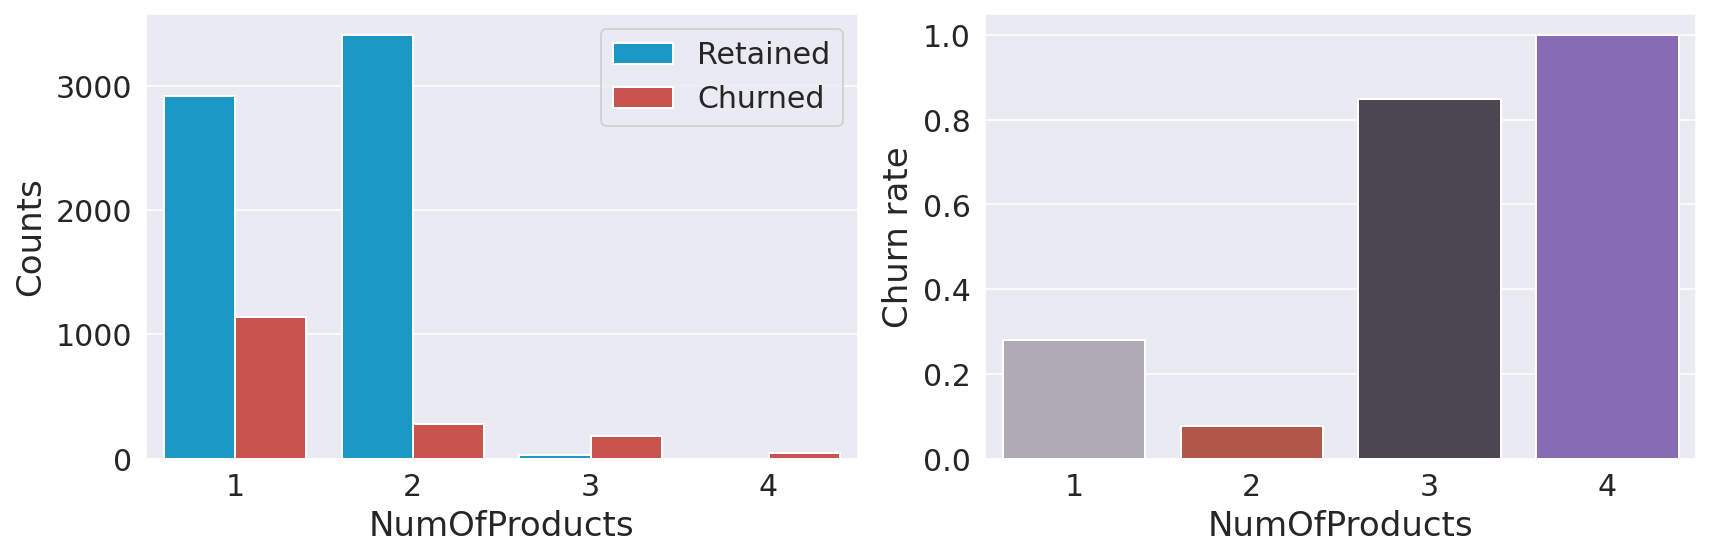

In [ ]:
plot_categorical('NumOfProducts')

Having 3 or 4 products significantly increases the likelihood of churn. It could potentially mean that the bank is unable to properly support customers with more products which in turn increases customer dissatisfaction.



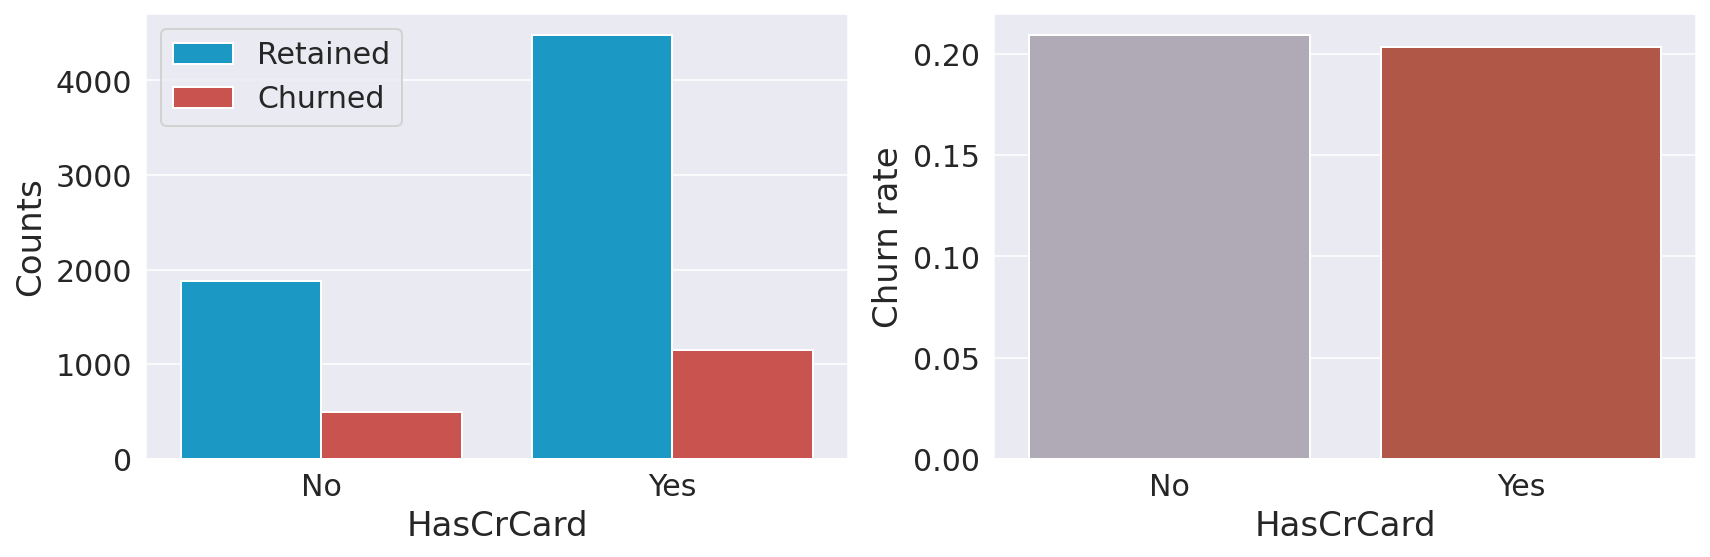

In [ ]:
plot_categorical('HasCrCard')


Having a credit card doesn't seem to affect the churn rate.

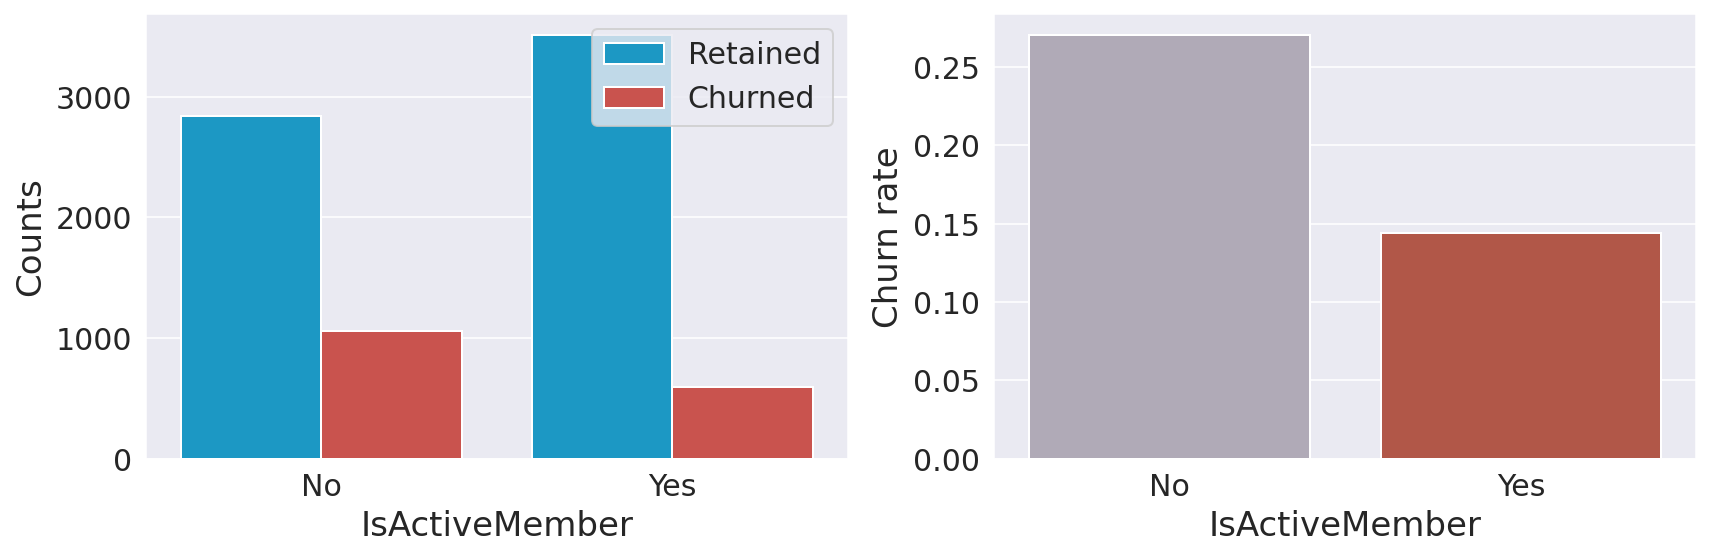

In [ ]:
plot_categorical('IsActiveMember')


It's not a surprise that inactive customers are more likely to churn. A big portion of the Client is inactive; therefore, the bank will definitely benefit from changing its policy so that more customers become active.


## Data Pre-processing

Data preprocessing is the process of converting raw data into a well-readable format that is suitable for building and training Machine Learning models.

### Feature Selection

I have already performed feature selection by dropping columns 'RowNumber', 'CustomerId', and 'Surname' at the beginning of our notebook. EDA revealed several more features that can be dropped as they do not provide any value in predicting our target variable:

'EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.
The categories in 'Tenure' and 'HasCrCard' have a similar churn rate and are deemed redundant. This can be confirmed from a chi-square test

In [ ]:
chi2_array, p_array = [], []
for column in cat_vars:
    
    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({'Variable': cat_vars, 
                       'Chi-square': chi2_array, 
                       'p-value': p_array})
df_chi.sort_values(by = 'Chi-square', ascending = False)

,Variable,Chi-square,p-value
3,NumOfProducts,1233.595,3.767e-267
0,Geography,230.748,7.829e-51
5,IsActiveMember,195.315,2.199e-44
1,Gender,90.173,2.183e-21
2,Tenure,15.197,1.250e-01
4,HasCrCard,0.301,5.833e-01


'Tenure' and 'HasCrCard' have a small chi-square and a p-value greater than 0.05 (the standard cut-off value), which confirms our initial hypothesis that these two features do not convey any useful information.

In [ ]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df.drop(features_drop, axis = 1, inplace = True) 

print ('Features dropped!')

Features dropped!


### Encoding Categorical Features

Machine learning algorithms usually require that all input (and output) features are numeric. Consequently, categorical features need to be converted (encoded) to numbers before using them for building models.

THe dataset contains two features that require encoding.

* For 'Gender', I have used scikit-learn's LabelEncoder() which maps each unique label to an integer (Male --> 1 and Female --> 0).
* For 'Geography', manually map values so that customers in Germany have the value of 1 and all other customers (France and Spain) have zero. I chose this method since the churn rate for customers in the other two countries is almost equal and considerably lower than in Germany. Therefore, it makes sense to encode this feature so that it differentiates between German and non-German customers.

In [ ]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({'Germany': 1, 'Spain': 0, 'France': 0})

print ('Features encoded!')

Features encoded!


### Scaling

Feature scaling is a technique used to normalise the range of features in a dataset. Some algorithms are sensitive to feature scaling (e.g. SVMs) while others are invariant to it (e.g. Random Forests).

I decided to use StandardScaler() which standardises features by subtracting the mean and dividing by the standard deviation. This results in features with zero mean and unit variance.



In [ ]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print ('Features scaled!')

Features scaled!


In [ ]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

print ('Sets created!')

Sets created!


### Class Imbalance

As we have seen previously, there is an imbalance in the classes to be predicted, with one class (0 – remained) much more prevalent than the other (1 - churned)

Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data is biased in favor of the majority class, meaning that machine learning algorithms will likely result in models that do little more than predict the most common class. Additionally, common metrics can be misleading when handling class-imbalanced data (e.g. if a dataset contains 99.9% 0s and 0.01% 1s, a classifier that always predicts 0 will have 99.9% accuracy).

I decided to use the SMOTE ('Synthetic Minority Oversampling Technique') algorithm which, finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighboring record, where the weight is generated separately for each predictor



In [ ]:
before_sm = Counter(y_train)
print(before_sm)

Counter({0: 6356, 1: 6356})


In [ ]:
over = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train, y_train = over.fit_resample(X_train, y_train)

after_sm = Counter(y_train)
print(after_sm)

Counter({0: 6356, 1: 6356})


## Model 1 - Logistic Regression


 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


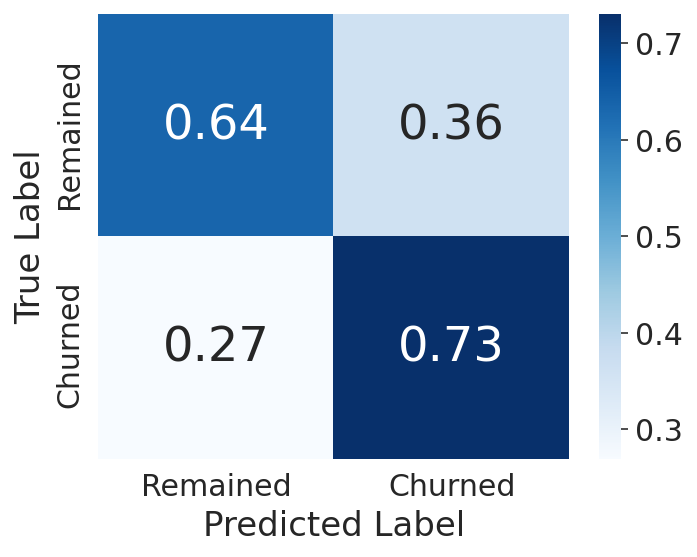

In [ ]:
lr = LogisticRegression(random_state = random_state)

param_grid = {'max_iter' : [100],
              'penalty' : ['l1', 'l2'],
              'C' : [0.001, 0.01, 0.1, 1, 10],
              'solver' : ['lbfgs', 'liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, scoring = scoring_metric, 
                      cv = 5, verbose = False, n_jobs = -1)

best_clf_lr = clf_lr.fit(X_train, y_train)
clf_performance(best_clf_lr, 'Logistic Regression', 'LR')